In [61]:
import pandas as pd 
import numpy as np
import torch 
import tiktoken 
import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv("train.csv")
data.head()

,Question,label
0,A solitaire game is played as follows. Six di...,3
1,2. The school table tennis championship was he...,5
2,"Given that $x, y,$ and $z$ are real numbers th...",0
3,$25 \cdot 22$ Given three distinct points $P\l...,1
4,I am thinking of a five-digit number composed ...,5


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  10189 non-null  object
 1   label     10189 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.3+ KB


In [63]:
label_to_text = {
    0:	"Algebra",
    1:	"Geometry and Trigonometry",
    2:	"Calculus and Analysis",
    3:	"Probability and Statistics",
    4:  "Number Theory",
    5:	"Combinatorics and Discrete Math",
    6:  "Linear Algebra",
    7:	"Abstract Algebra and Topology"
}
data['label_text'] = data['label'].map(label_to_text)
data.head()

,Question,label,label_text
0,A solitaire game is played as follows. Six di...,3,Probability and Statistics
1,2. The school table tennis championship was he...,5,Combinatorics and Discrete Math
2,"Given that $x, y,$ and $z$ are real numbers th...",0,Algebra
3,$25 \cdot 22$ Given three distinct points $P\l...,1,Geometry and Trigonometry
4,I am thinking of a five-digit number composed ...,5,Combinatorics and Discrete Math


[2618. 2439. 1039.  368. 1712. 1827.  186.]
[0. 1. 2. 3. 4. 5. 6. 7.]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5]
<BarContainer object of 7 artists>


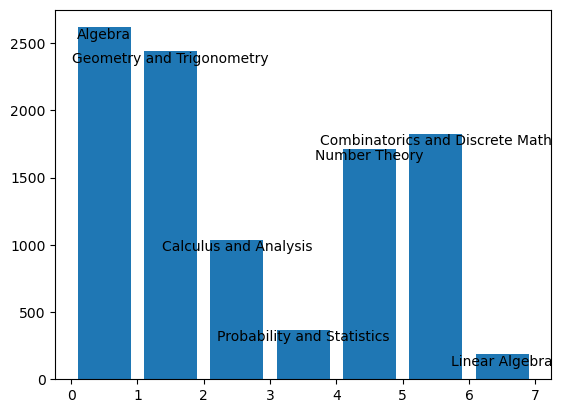

In [ ]:
# y value, bins/ categories, 
n, bins, _ = plt.hist(data['label'], bins = np.arange(8), rwidth=0.8)
bin_centers = (bins[:-1] + bins[1:]) / 2
print(n) 
print(bins)
print(bin_centers)
for x, y, label in zip(bin_centers, n, bins):
    plt.text(x,y, label_to_text[label], ha= 'center', va = 'top')

## Format the dataset

In [91]:
## we will follow this format: 
# [
#   [
#   {"role": "user", "content": "<math question>"},
#   {"role": "assistant", "content": "<label>"}
#   ]
# ...]
dataset = []
def format_dataset(data):
    for i in range(len(data)):
        datapoint = []
        datapoint.append({"role": "user", "content": data['Question'][i]})
        datapoint.append({"role": "assistant", "content": str(data['label'][i])})
        dataset.append(datapoint)
format_dataset(data)
dataset[0]


[{'role': 'user',
  'content': "A solitaire game is played as follows.  Six distinct pairs of matched tiles are placed in a bag.  The player randomly draws tiles one at a time from the bag and retains them, except that matching tiles are put aside as soon as they appear in the player's hand.  The game ends if the player ever holds three tiles, no two of which match; otherwise the drawing continues until the bag is empty.  The probability that the bag will be emptied is $p/q,\\,$ where $p\\,$ and $q\\,$ are relatively prime positive integers.  Find $p+q.\\,$ "},
 {'role': 'assistant', 'content': '3'}]

In [94]:
pip install trl 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for trl from https://files.pythonhosted.org/packages/6e/c3/d7f45cc0078d789558bd6601f246ae83d85ce95ceb01320569360cfe943d/trl-0.18.1-py3-none-any.whl.metadata
  Obtaining dependency information for accelerate>=0.34.0 from https://files.pythonhosted.org/packages/f8/bb/be8146c196ad6e4dec78385d91e92591f8a433576c4e04c342a636fcd811/accelerate-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for datasets>=3.0.0 from https://files.pythonhosted.org/packages/20/34/a08b0ee99715eaba118cbe19a71f7b5e2425c2718ef96007c325944a1152/datasets-3.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for transformers>=4.50.0 from https://files.pythonhosted.org/packages/96/f2/25b27b396af03d5b64e61976b14f7209e2939e9e806c10749b6d277c273e/transformers-4.52.4-py3-none-any.whl.metadata
  Obtaining dependency information for safetensors>=0.4.3 from https://files.pythonhosted.org/packages/b8/3b/11f1b4a2f5d2ab7da34ecc062b0bc301f2be024d110a6466726bec8c055c

In [100]:
from trl import SFTConfig, SFTTrainer
## Configure the SFT (supervised fine-tuning)
sft_config = SFTConfig(
    # Group 1: memory-related
    gradient_checkpointing=True,    # this saves a LOT of memory
    gradient_checkpointing_kwargs={'use_reentrant': False}, 
    # Actual batch (for updating) is same (1x) as micro-batch size
    gradient_accumulation_steps=1,  
    # The initial (micro) batch size to start off with
    per_device_train_batch_size=16, 
    # If batch size would cause OOM, halves its size until it works
    auto_find_batch_size=True,
    ## GROUP 2: Dataset-related
    max_seq_length=6668,
    # Dataset
    # packing a dataset means no padding is needed
    packing=False,
    ## GROUP 3: These are typical training parameters
    num_train_epochs=2, #TODO: train only 2 epochs for now 
    learning_rate=3e-4,
    # Optimizer
    # 8-bit Adam optimizer - doesn't help much if you're using LoRA!
    optim='paged_adamw_8bit',       
    ## GROUP 4: Logging parameters
    logging_steps=10,
    logging_dir='./logs',
    output_dir='./qwen2.5-0.5b-v1',
    report_to='none'
)


RuntimeError: Failed to import trl.trainer.sft_config because of the following error (look up to see its traceback):
Failed to import transformers.training_args because of the following error (look up to see its traceback):
cannot import name 'is_torch_hpu_available' from 'transformers.utils' (/Users/hendy/anaconda3/lib/python3.11/site-packages/transformers/utils/__init__.py)

## Load the model (Qwen 0.5b)

In [69]:
from transformers import AutoTokenizer, Qwen2ForSequenceClassification
num_labels = 8
# load the tokenizer and pretrained weights 
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
model = Qwen2ForSequenceClassification.from_pretrained(
    "Qwen/Qwen2.5-0.5B", num_labels=num_labels, problem_type="multi_label_classification"
)


model.safetensors:  32%|###1      | 315M/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=sft_config,
    train_dataset=dataset,
)
dl = trainer.get_train_dataloader()
batch = next(iter(dl))
print("inputs:", batch['input_ids'][0], "outputs:", batch['labels'][0])

In [ ]:
trainer.train()

In [86]:
model

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen

In [85]:
# tokenize the input 
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# generate some output 
with torch.no_grad():
    logits = model(**inputs).logits
    print((logits))
predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]
labels = torch.sum(
    torch.nn.functional.one_hot(predicted_class_ids[None, :].clone(), num_classes=num_labels), dim=1
).to(torch.float)

# get the loss 
loss = model(**inputs, labels=labels).loss
print(loss)


tensor([[  6.9069,   9.3034,  -1.9795,  -6.4893, -10.4719,   3.0153,   7.2252,
          18.0469]])
tensor(0.0226, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=sft_config,
    train_dataset=dataset,
)


In [ ]:
ignore_mismatched_sizes=True
#TODO: try LoRA and quantization 
